In [11]:
######################################
# Author: J.Tang
# Date: 2025-04-28
# Purpose: Data cleaning and preprocessing for credit card default prediction 
######################################


import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import os 
# Set working directory to project root
os.chdir('C:/Users/j.tang/ml-coding-template/credit-card-default-tutorial/')
data = pd.read_csv('./data/processed/filtered_data.csv')
data = data.iloc[:,1:]


# Data Preprocessing

The quality of the data and the amount of useful information that are contained are key factors that determine how well a machine learning algorithm can learn. Therefore, it is absolutely critical to ensure that we examine and preprocess our dataset before we feed it to a learning algorithm.


## Handling categorical features

The categorical features EDUCATION, SEX, and MARRIAGE are already encoded with integer numbers and could be fed to a machine learning algorithm. However, these are nominal features, for which it would be sub-optimal to assume an ordering. One-hot encoding allows us to remove any ordinal relationship, which would be meaningless between these categorical variables. The idea behind this approach is to create a new dummy feature for each unique value in the nominal feature column. Binary values can then be used to indicate the particular class of an example.


Although Scikit-Learn provides methods to perform one-hot encoding automatically, we decide to do the mapping of the features by hand, since there are few. In this way we mitigate the problem of multicollinearity, which occurs when there are highly correlated features. Thus, we create the following boolean columns and drop the old ones, EDUCATION, SEX, and MARRIAGE.

- MALE: 1 = male; 0 = female.
- MARRIED: 1 = married marital status; 0 = otherwise.
- GRAD_SCHOOL: 1 = graduate school level of education; 0 = otherwise.
- UNIVERSITY: 1 = university level of education; 0 = otherwise.
- HIGH_SCHOOL: 1 = high school level of education; 0 = otherwise.

Note that we do not lose any important information by removing a feature column, though; for example, we removed the column EDUCATION=4 (others), but the feature information is still preserved, since if we observe GRAD_SCHOOL=0, UNIVERSITY=0 and HIGH_SCHOOL=0, it implies that the observation must be OTHERS.


In [3]:
data['GRAD_SCHOOL'] = (data['EDUCATION'] == 1).astype('category')
data['UNIVERSITY'] = (data['EDUCATION'] == 2).astype('category')
data['HIGH_SCHOOL'] = (data['EDUCATION'] == 3).astype('category')
data.drop('EDUCATION', axis=1, inplace=True)

data['MALE'] = (data['SEX'] == 1).astype('category')
data.drop('SEX', axis=1, inplace=True)

data['MARRIED'] = (data['MARRIAGE'] == 1).astype('category')
data.drop('MARRIAGE', axis=1, inplace=True)

data.head()


,ID,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0,0,0,0,1,False,True,False,False,True
1,2,120000,26,-1,2,0,0,0,2,2682,...,1000,1000,0,2000,1,False,True,False,False,False
2,3,90000,34,0,0,0,0,0,0,29239,...,1000,1000,1000,5000,0,False,True,False,False,False
3,4,50000,37,0,0,0,0,0,0,46990,...,1200,1100,1069,1000,0,False,True,False,False,True
4,6,50000,37,0,0,0,0,0,0,64400,...,657,1000,1000,800,0,True,False,False,True,False


## Dataset Partition
To evaluate the generalization ability of the machine learning algorithms we are going to use, we separate the dataset into training set and test set. Un particular, we apply stratification on the target variable DEFAULT to ensure that relative class frequencies are approximately preserved in both train and test split. We set random_state = 24 to make the experiments repeatable.




In [5]:
# split the dataset into training and test set
y = data['DEFAULT']
X = data.drop('DEFAULT', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24, stratify=y)

# Print the shapes of training and test sets to verify the split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Print the class distribution in the training and test sets
print(f"Training set class distribution: {y_train.value_counts()}")
print(f"Test set class distribution: {y_test.value_counts()}")


Training set shape: (17967, 26)
Test set shape: (5990, 26)
Training set class distribution: DEFAULT
0    13982
1     3985
Name: count, dtype: int64
Test set class distribution: DEFAULT
0    4661
1    1329
Name: count, dtype: int64


# Feature Scaling 
The majority of machine learning and optimization algorithms behave much better if numerical features are on the same scale. Decision trees and random forests are two of the very few machine learning algorithms where there is no need to worry about feature scaling, as they are scale invariant. 


There are two common approaches to bringing different features onto the same scale: normalization and standardization. Normalization refers to the rescaling of the features to a range of [0,1]
, which is a special case of min-max scaling:

$ X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} $

Here, $X$ is a particular example, $X_{min} is the smallest value and X_{max} is the largest value 


Using standardization, we center the feature columns at mean $\mu = 0$ with standard deviation $\sigma = 1$  so that the feature columns have the same parameters as a standard normal distribution, which makes it easier to learn the weights.

$ Z = \frac{X- \mu}{\sigma}$

While normalization suppress the effect of outliers, standardization mantains information about them. Since the technique we will apply shortly is sensitive to the presence of outliers, we decide to continue our study with the normalized data.



In [7]:
# Initialize the MinMaxScaler for normalizing features to [0,1] range
scaler = MinMaxScaler()

# Create copies of train and test sets to store normalized values
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

# Normalize LIMIT_BAL feature
# Fit scaler on training data and transform both train and test
X_train_norm['LIMIT_BAL'] = scaler.fit_transform(X_train['LIMIT_BAL'].values.reshape(-1, 1))
X_test_norm['LIMIT_BAL'] = scaler.transform(X_test['LIMIT_BAL'].values.reshape(-1, 1))

# Normalize AGE feature
X_train_norm['AGE'] = scaler.fit_transform(X_train['AGE'].values.reshape(-1, 1))
X_test_norm['AGE'] = scaler.transform(X_test['AGE'].values.reshape(-1, 1))

# Normalize payment history (PAY_), bill amounts (BILL_AMT) and payment amounts (PAY_AMT) 
# for all 6 months of data
for i in range(1,7):
    # Normalize payment history indicators
    X_train_norm['PAY_' + str(i)] = scaler.fit_transform(X_train['PAY_' + str(i)].values.reshape(-1, 1))
    X_test_norm['PAY_' + str(i)] = scaler.transform(X_test['PAY_' + str(i)].values.reshape(-1, 1))
    
    # Normalize bill amounts
    X_train_norm['BILL_AMT' + str(i)] = scaler.fit_transform(X_train['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_test_norm['BILL_AMT' + str(i)] = scaler.transform(X_test['BILL_AMT' + str(i)].values.reshape(-1, 1))
    
    # Normalize payment amounts
    X_train_norm['PAY_AMT' + str(i)] = scaler.fit_transform(X_train['PAY_AMT' + str(i)].values.reshape(-1, 1))
    X_test_norm['PAY_AMT' + str(i)] = scaler.transform(X_test['PAY_AMT' + str(i)].values.reshape(-1, 1))

C:\Users\j.tang\AppData\Local\Temp\ipykernel_13476\2356808966.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels=numeric, rotation=25)
C:\Users\j.tang\AppData\Local\Temp\ipykernel_13476\2356808966.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels=numeric, rotation=25)


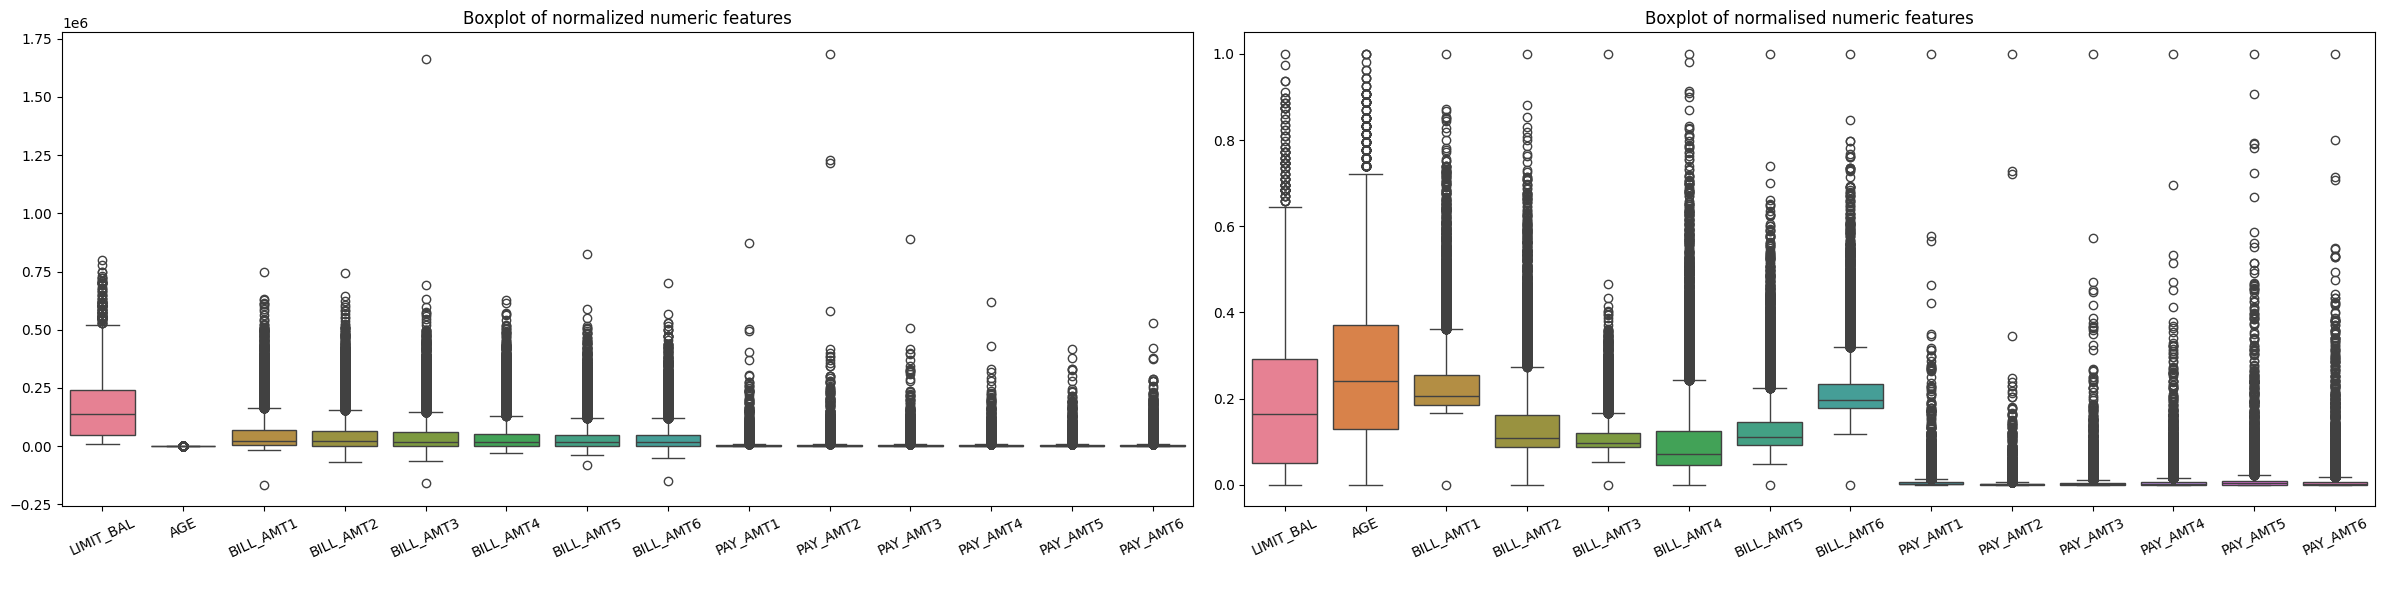

In [9]:
sns.set_color_codes('deep')
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
fig, axs = plt.subplots(1, 2, figsize=(24,6))

sns.boxplot(data=X_train[numeric], ax=axs[0])
axs[0].set_title('Boxplot of normalized numeric features')
axs[0].set_xticklabels(labels=numeric, rotation=25)
axs[0].set_xlabel(' ')

sns.boxplot(data=X_train_norm[numeric], ax=axs[1])
axs[1].set_title('Boxplot of normalised numeric features')
axs[1].set_xticklabels(labels=numeric, rotation=25)
axs[1].set_xlabel(' ')

fig.tight_layout()
plt.savefig('./reports/figures/raw_vs_normalized.svg')
plt.show()

# Dealing with class imbalance 

We showed before the dataset we are dealing with is unbalanced, as the non-defaulter examples are over-represented. Actually, class imbalance is a quite common problem when working with real-world data.




In [10]:
class_count = [y_train[y_train == 0].count(), y_train[y_train == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion')
class_count_df

Training set class proportion


,Number,Percentage
Non-defaulters,13982,77.82%
Defaulters,3985,22.18%


In our case, we could achieve almost 80% accuracy by just predicting the majority class (non-defaulters) for all examples, without the help of a supervised machine learning algorithm. Thus, when we will fit classifiers on our datasets, it would make sense to focus on other metrics than accuracy when comparing different models.

- Aside from evaluating machine learning models, class imbalance influences a learning algorithm during model fitting itself. Since machine learning algorithms typically optimize a reward or cost function that is computed as a sum over the training examples that it sees during fitting, the decision rule is likely going to be biased toward the majority class.
- exclude the naïve methods of oversampling (undersampling), since they randomly duplicate (delete) data from the minority (majority) class, until the desired level is obtained. On the one hand, random undersampling does not allow to control which information is discarded, on the other hand random oversampling causes overfitting because the model is trained on many identical data. 





## Synthetic Minority Oversampling Technique (SMOTE)
The Synthetic Minority Oversampling Technique (SMOTE) was proposed in to avoid the risk of overfitting faced by random oversampling. Instead of merely replicating existing observations, the technique generates artificial samples. As shown in Figure below, this is achieved by linearly interpolating a randomly selected minority observation and one of its neighboring minority observations. More precisely, SMOTE executes three steps to generate a synthetic sample.

1. Firstly, it chooses a random minority observation $\overrightarrow{a}$
2. Among its $k$ nearest minority class neighbors, instance $\overrightarrow{b}$ is randomly selected
3. Finally, a new sample  $\overrightarrow{x}$ is created by randomly interpolating the two sample: $\overrightarrow{x} = \overrightarrow{a} + w \times (\overrightarrow{b} - \overrightarrow{a})$ where $w$ is a random weight in $[0,1]$

![SMOTE illustration](./references/smote1.png)



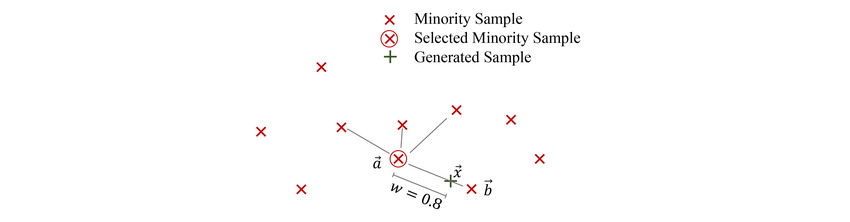

In [13]:
from IPython.display import Image
Image(filename='./references/smote1.png')
